# MNIST handwritten digits classification with CNNs

Sam Foreman  
*2025-08-06*

::: {.callout-note title="Authors" icon="false" collapse="true"}
> Modified from original content written by:
>
> ```
> Bethany Lusch        (ANL)
> Varuni Sastry        (ANL)
> Kyle Felker          (ANL)
> Corey Adams          (AMD  ← ANL)
> Prasanna Balprakash  (ORNL ← ANL)
> ```
:::

In this notebook, we'll continue the MNIST problem but incorporate convolutional
layers.

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saforem2/intro-hpc-bootcamp-2025/blob/main/content/01-neural-networks/2-advanced/index.ipynb) [![](https://img.shields.io/badge/-View%20on%20GitHub-333333?style=flat&logo=github&labelColor=gray.png)](https://github.com/saforem2/intro-hpc-bootcamp-2025/blob/main/docs/01-neural-networks/2-advanced/README.md)

First, we will import the required library and frameworks.

In [11]:
%load_ext autoreload
%autoreload 2
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'svg', 'png')
import matplotlib.pyplot as plt
import ambivalent
plt.style.use(ambivalent.STYLES['ambivalent'])
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## MNIST data set

Again we'll load the MNIST handwritten digits data set. 

In [3]:
training_data = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

100%|████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 34.5MB/s]|██████▏                                                                              | 721k/9.91M [00:00<00:01, 7.14MB/s] 44%|████████████████████████████████████▉                                               | 4.36M/9.91M [00:00<00:00, 22.0MB/s]|██████▏                                                                              | 721k/9.91M [00:00<00:01, 7.14MB/s]
  0%|                                                                                             | 0.00/28.9k [00:00<?, ?B/s]100%|████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]  0%|                                                                                             | 0.00/28.9k [00:00<?, ?B/s]
  0%|                                                                                             | 0.00/1.65M [00:00<?, ?B/

In [4]:
training_data, validation_data = torch.utils.data.random_split(
    training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55)
)

This time we won't flatten the images. 

The training data input is a 3rd-order tensor of size (48000, 28, 28), i.e. it consists of 48,000 images of size 28x28 pixels. 

The labels for the training data are in a 48,000-dimensional vector containing the correct classes ("0", "1", ..., "9") for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images. They are very similar to any other neural network being built with neurons that have learnable weights and biases. Each neuron receives a input, then a dot product with the weights and bias followed with some non-linear operation. The network still represents a function mapping from raw input (pixels in case of images) to a class score. All is good for small resolution images. What happens when the image is 256x256x3 ? The very first hiddden layer in a fully connected neural network will have 196K parameters! So fully connected neural networks do not scale well for images. 

A typical convolutional neural network architecture consists of :
* Convolutional Layer,
* Pooling Layer, and 
* Fully-Connected Layer



::: {#fig-conv-layer-1}

![](images/convNN_BlockDiagram.jpeg)

Convolutional Layer.
Image credit:
[Sumit Saha](https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/)
:::

Let's use a small model that includes convolutional layers

- The Conv2d layers operate on 2D matrices so we input the digit images directly to the model.
  - The two Conv2d layers below learn 32 and 64 filters respectively. 
  - They are learning filters for 3x3 windows.
- The MaxPooling 2D layer reduces the spatial dimensions, that is, makes the image smaller.
  - It downsamples by taking the maximum value in the window 
  - The pool size of 2 below means the windows are 2x2. 
  - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

In [12]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.drop_3 = nn.Dropout(p=0.25)
        self.dense_4 = nn.Linear(in_features=9216, out_features=128)
        self.drop_5 = nn.Dropout(p=0.5)
        self.dense_6 = nn.Linear(in_features=128, out_features=10)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = nn.functional.relu(x)

        x = self.conv_2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2)

        x = self.drop_3(x)
        x = torch.flatten(x, start_dim=1)

        x = self.dense_4(x)
        x = nn.functional.relu(x)

        x = self.drop_5(x)

        x = self.dense_6(x)
        x = nn.functional.softmax(x, dim=1)

        return x

### Convolutional Basics

A convolution layer is formed by convolving a filter (usually 5x5 or 3x3)
repeatedly over the input image to create a feature map, meaning the filter
slides over spatially from the top left corner of the image to the bottom right
corner of the image. Filters learn different features and detect the patterns in
an image.

::: {#fig-conv-layer-2}

![](images/conv_layer.png)

Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)
:::

::: {#fig-conv-layer-3}

![](images/conv.png)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)
:::

### Padding

Adds zeros along the corners of the image to preserve the dimensionality of the
input.

::: {#fig-conv-padding}

![](images/Padding.png)

:::

### What is the output size ?

$$(\mathrm{N} - \mathrm{F} + 2\mathrm{P}) / \mathrm{S} + 1$$

- where
  - $N$ = dimension of the input image. (ex, for an image of `28x28x1`, $N=28$)
  - $F$ = dimension of the filter ($F=3$ for a filter of `3x3`)
  - $S$ = Stride value
  - $P$ = Size of the zero padding used

### Max Pooling

Pooling reduces the dimensionality of the images, with max-pooling being one of the most widely used.

::: {#fig-conv-max-pool-1}

![](images/MaxpoolSample2.png)
:::

### Multiple Channels

Usually colored images have multiple channels with RGB values. What happens to the filter sizes and activation map dimensions in those cases?

::: {#fig-multiple-channels}

![](images/multiple_channels.png)

:::

### Visualizing learned features from CNNs

The filters from the initial hidden layers tend to learn low level features like
edges, corners, shapes, colors etc.
Filters from the deeper layers tend to learn high-level features detecting
patterns like wheel, car, etc.

::: {#fig-conv-nets-feature-maps}

![](images/convnets-feature-maps.png)
:::

Now we can train the network, similarly to the previous notebook.

In [6]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [7]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100 * correct
    return accuracy, loss

In [8]:
def train_network(batch_size, epochs, lr):
    cnn_model = MNISTClassifier()
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = numpy.zeros((epochs, 4))

    for j in range(epochs):
        train_one_epoch(train_dataloader, cnn_model, loss_fn, optimizer)

        # checking on the training & val loss and accuracy once per epoch
        acc_train, loss_train = evaluate(train_dataloader, cnn_model, loss_fn)
        acc_val, loss_val = evaluate(val_dataloader, cnn_model, loss_fn)
        print(f"Epoch {j}: val. loss: {loss_val:.4f}, val. accuracy: {acc_val:.4f}")
        history[j, :] = [acc_train, loss_train, acc_val, loss_val]

    return history, cnn_model

In [9]:
%%time

batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network(batch_size, epochs, lr)

Epoch 0: val. loss: 1.4972, val. accuracy: 96.3750
Epoch 1: val. loss: 1.4928, val. accuracy: 96.8667
2: val. loss: 1.4946, val. accuracy: 96.6833

CPU times: user 4min 21s, sys: 57.4 s, total: 5min 19s
Wall time: 2min 3s


The model should be better than the non-convolutional model even if you're only
patient enough for three epochs.

Text(0, 0.5, 'accuracy')

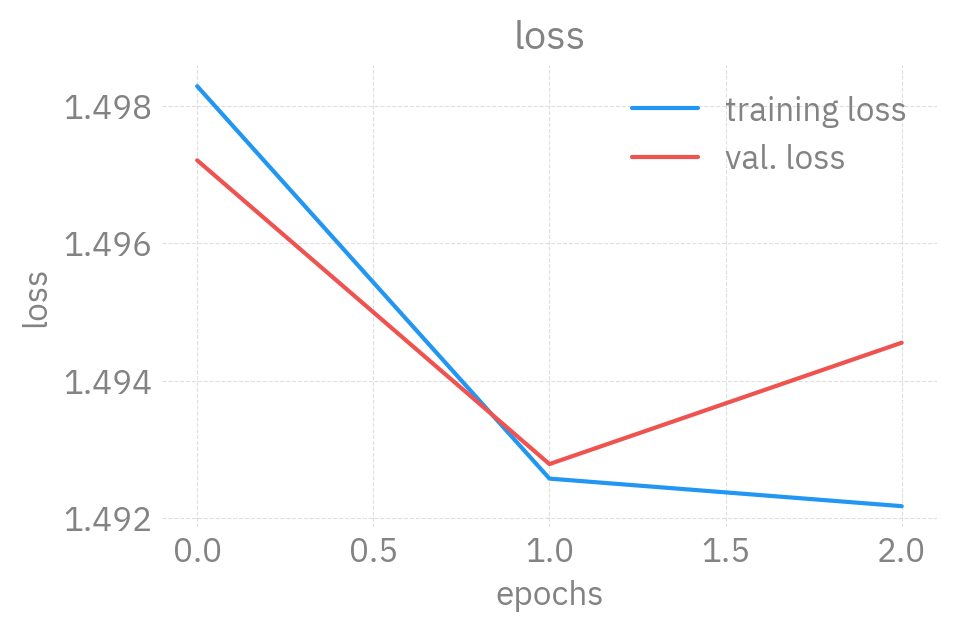

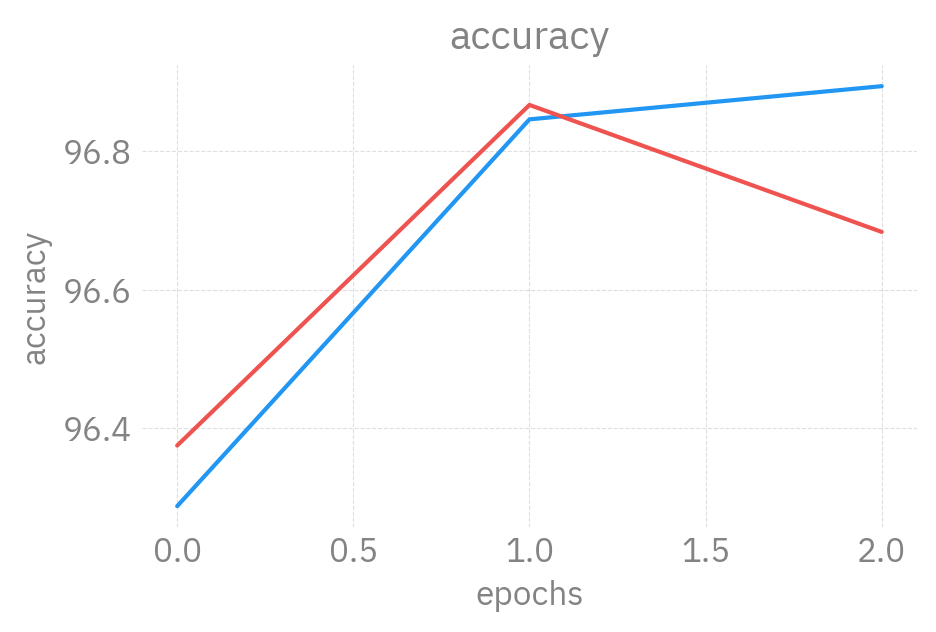

In [10]:
plt.figure(figsize=(5, 3))
plt.plot(range(epochs), history[:, 1], label="training loss")
plt.plot(range(epochs), history[:, 3], label="val. loss")
plt.title("loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.figure(figsize=(5, 3))
plt.plot(range(epochs), history[:, 0], label="training accuracy")
plt.plot(range(epochs), history[:, 2], label="val. accuracy")
plt.title("accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). Even more results can be found [here](http://yann.lecun.com/exdb/mnist/).

## Advanced networks

### ResNet

Deeper and deeper networks that stack convolutions end up with smaller and
smaller gradients in early layers.
ResNets use additional skip connections where
the output layer is `f(x) + x` instead of `f(w x + b)` or `f(x)`.
This avoids vanishing gradient problem and results in smoother loss functions.
Refer to the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) and
[ResNet loss visualization paper](https://arxiv.org/pdf/1712.09913.pdf)
for more information.

::: {#fig-resnet}

![](images/ResNet.png)

ResNet. Image credit: [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf)
:::

### U-Nets

U-NET is a convolution based neural network architecture orginally developed for
biomedical image segmentation tasks.
It has an encoder-decoder architecture with skip connections in between them.

::: {#fig-u-nets}

![](images/U-Nets.png)

Image credit: [ResNet paper](https://arxiv.org/pdf/1505.04597.pdf)
:::

### ViTs

You'll learn about language models today, which use "transformer" models.
There has been some success applying transformers to images ("vision
transformers").
To make images sequential, they are split into patches and flattened.
Then apply linear embeddings and positional embeddings and feed it to a
encoder-based transformer model.

::: {#fig-vits}

![](images/ViT.gif)

Image credit:
[Google Blog](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
:::